In [1]:
pip install tifffile imagecodecs graphlearning

     |████████████████████████████████| 30.0MB 96kB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 655kB 20.0MB/s 
     |████████████████████████████████| 102kB 10.1MB/s 
  Created wheel for graphlearning: filename=graphlearning-0.0.2-cp37-cp37m-linux_x86_64.whl size=114512 sha256=4d6b110c02c5f5fc153f2518fb6de16967e1a4cb887fd80dd0885c6e3ef8b6a8
  Stored in directory: /root/.cache/pip/wheels/93/a8/72/0b58bcca9ee4fba7654f05b14a74adc8cc8f330a5c6d29dafc
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391636 sha256=a660115862054f4c33ba5076b7436d2e56126b031e973dd0adffd0e7fdea041f
  Stored in directory: /root/.cache/pip/wheels/3a/c5/59/cce7e67b52c8e987389e53f917b6bb2a9d904a03246fadcb1e
Successfully built graphlearning annoy


In [2]:
## Import useful packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale, resize
import graphlearning as gl
from scipy import sparse
from sklearn.cluster import KMeans
from tifffile.tifffile import imread
import urllib.request

In [3]:
## Function for Non-Local Means Method
def NonLocalMeans(image, d):
  
  ## Pad the image with mirror reflections of itself with a width d
  pad = (d,d)
  padimage = np.pad(image,(pad,pad,(0,0)),mode='reflect') #(top,bottom),(left,right),(0,0)

  ## For the ith pixel, make a (2d + 1) by (2d + 1) patch centered at pixel i
  patches = extract_patches_2d(padimage, (2*d+1,2*d+1))

  ## For the jth, (j = 1; 2; 3) band, apply a Gaussian kernel on this patch
  u = np.zeros((2*d+1,2*d+1))
  u[d,d] = 1
  G = gaussian_filter(u,d/2,mode='constant',cval=0)
  patches = patches * G[np.newaxis,:,:,np.newaxis]

  ## Form the feature matrix F by letting each row of F be a feature vector of a pixel
  F = patches.reshape((patches.shape[0],patches.shape[1]*patches.shape[2]*patches.shape[3]))

  ## (I,J) coordinates of all pixels in the image
  I,J = np.mgrid[0:image.shape[0],0:image.shape[1]]
  I = I.flatten()[:,np.newaxis]
  J = J.flatten()[:,np.newaxis]

  ## Append I and J at the end of F as column vectors
  w = 0.05
  F = np.hstack((F,w*I,w*J))

  return F

In [4]:
## Function to generate the weight matrix
def WeightMatrix(data):
  boolean = False
  k=1
  I,J,D = gl.knnsearch_annoy(data,50)

  while boolean==False:
    k+=1
    W = gl.weight_matrix(I,J,D,k)
    boolean = gl.isconnected(W)
    print("k=%d"%k, "connected=%s"%boolean)

  k=2*k
  W = gl.weight_matrix(I,J,D,k)
  print("k=%d"%k, "connected=%s"%boolean)

  return W

In [5]:
## Function to perform spectral clustering and plot the image segmentation
def spectral_clustering(W, num_cluster, image):

  ##Spectral Embedding
  L = gl.graph_laplacian(W, norm='normalized')
  vals, vec = sparse.linalg.eigs(L,k=num_cluster+1,which='SM')
  vals = vals[1:].real
  vec = vec[:,1:].real  
  norm = np.sum(vec**2,axis=1)
  Y = vec/norm[:,np.newaxis]**.5 

  ##K-means
  kmeans = KMeans(n_clusters=num_cluster).fit(Y)
  labels_cluster = kmeans.labels_

  ##Plot original image
  plt.figure()
  plt.title('original image')
  plt.imshow(image)

  ##Plot image segmentation
  image_seg = np.reshape(labels_cluster,image.shape[0:2])
  plt.figure()
  plt.title('image segmentation')
  plt.imshow(image_seg)

  ##Plot eigenvectors
  for i in range(num_cluster):
    eigen_vec = vec[:,i].reshape((image.shape[0],image.shape[1]))
    plt.figure()
    plt.title('eigenvector %s'%i)
    plt.imshow(eigen_vec, cmap='gray')

In [6]:
## Function to combine the whole process
def image_segmentation(image, window_size, num_cluster):
  F = NonLocalMeans(image, window_size)
  W = WeightMatrix(F)
  spectral_clustering(W, num_cluster, image)

(213, 320, 3)


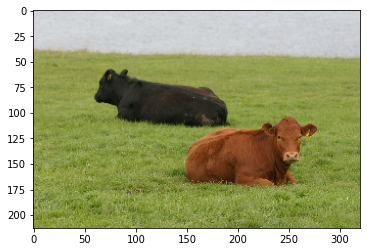

In [7]:
## Import the cow image
urllib.request.urlretrieve('https://github.com/jwcalder/TestImages/blob/main/cow.tiff?raw=true','cow.tiff')
img = imread('cow.tiff')
img = img.astype('int16')
print(img.shape)
plt.imshow(img)
plt.show()

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=True
k=10 connected=True


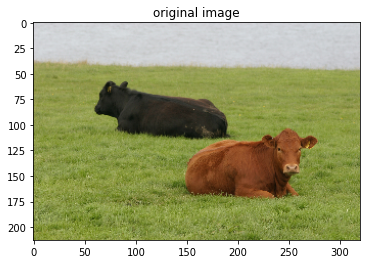

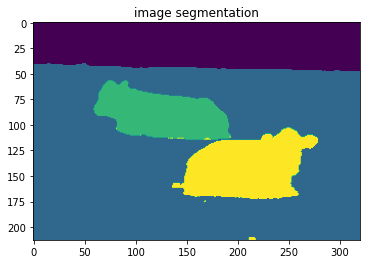

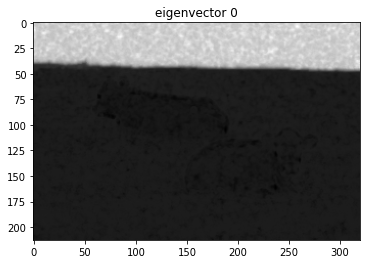

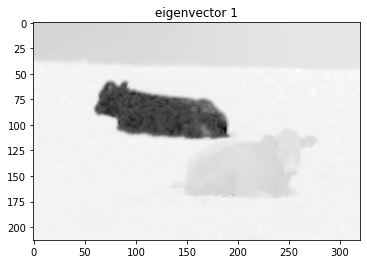

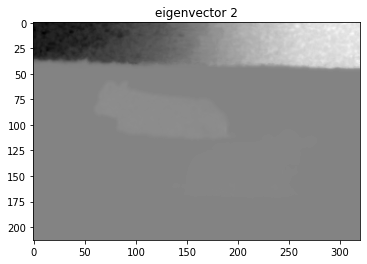

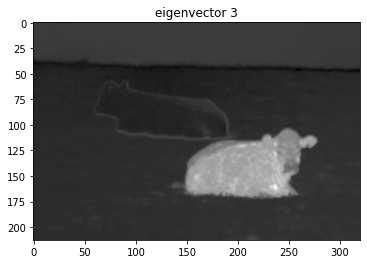

In [8]:
#image segmentation of original image
image_segmentation(img, window_size=3, num_cluster=4)